# Imports

In [27]:
import os
import sys
import itertools
from typing import List

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
sys.path.append("../../")
sys.path.append("../../source_code")

from source_code import (utils, analysis, feature_engineering, modelling)

print("Last Modified: ", utils.current_timestamp())

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Last Modified:  08-02-2021_23-50-27


In [2]:
data_path = '~/../../media/sf_data/'
data_path = '/Users/jeremy/data/'

In [3]:
train = pd.read_csv(data_path + 'air_pollution_predictor/train.csv')
test = pd.read_csv(data_path + 'air_pollution_predictor/test.csv')

# EDA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_time               7111 non-null   object 
 1   deg_C                   7111 non-null   float64
 2   relative_humidity       7111 non-null   float64
 3   absolute_humidity       7111 non-null   float64
 4   sensor_1                7111 non-null   float64
 5   sensor_2                7111 non-null   float64
 6   sensor_3                7111 non-null   float64
 7   sensor_4                7111 non-null   float64
 8   sensor_5                7111 non-null   float64
 9   target_carbon_monoxide  7111 non-null   float64
 10  target_benzene          7111 non-null   float64
 11  target_nitrogen_oxides  7111 non-null   float64
dtypes: float64(11), object(1)
memory usage: 666.8+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          2247 non-null   object 
 1   deg_C              2247 non-null   float64
 2   relative_humidity  2247 non-null   float64
 3   absolute_humidity  2247 non-null   float64
 4   sensor_1           2247 non-null   float64
 5   sensor_2           2247 non-null   float64
 6   sensor_3           2247 non-null   float64
 7   sensor_4           2247 non-null   float64
 8   sensor_5           2247 non-null   float64
dtypes: float64(8), object(1)
memory usage: 158.1+ KB


In [6]:
train.head(2)

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.100,46.000,0.758,1387.200,1087.800,1056.000,1742.800,1293.400,2.500,12.000,167.700
1,2010-03-10 19:00:00,13.200,45.300,0.726,1279.100,888.200,1197.500,1449.900,1010.900,2.100,9.900,98.900


In [7]:
TARGET_COLUMNS =  [col for col in train.columns if 'target' in col]    
FEATURE_COLUMNS = [col for col in train.columns if col not in TARGET_COLUMNS]
ORIGINAL_NUM_FEATURE_COLUMNS = train[FEATURE_COLUMNS].select_dtypes(include=np.number).columns

# Feature Engineering

In [8]:
def feature_hourly_lag(df: pd.DataFrame, lag_features: List[str], lags: List[int]) -> pd.DataFrame:
    for feature, lag in itertools.product(lag_features, lags):
        df[feature + '_' + str(lag) + '_lag'] = df[feature] - df[feature].shift(periods=lag, fill_value=0)
    return df
        
def data_preprocessing(df) -> pd.DataFrame:
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['year'] = df['date_time'].dt.year
    df['month'] = df['date_time'].dt.month
    df['week'] = df['date_time'].dt.week
    df['day'] = df['date_time'].dt.day
    df['day_of_week'] = df['date_time'].dt.dayofweek
    df['hour'] = df['date_time'].dt.hour
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['working_hours'] = (df['hour'].isin(np.arange(7, 20))).astype(int)
    df['night_hours'] = (~(df['hour'].isin(np.arange(6, 22)))).astype(int)
    df['season'] = feature_engineering.get_season_from_date_time_feature(
        df['date_time'])
    # df.drop(['date_time'],axis=1, inplace=True)

    # SMC - Site mean concentration, calculation: (absolute_humid * 100)/(relative humidity)
    df['smc'] = (100 * df['absolute_humidity']) / df['relative_humidity']

    # Introduce Lags
    df = feature_hourly_lag(df, ['sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','smc', 'absolute_humidity', 'deg_C'], [1,2,3,6,12,24])
    
    df.replace(to_replace=np.inf, value=0, inplace=True)
    return df

In [9]:
train = data_preprocessing(train)
test = data_preprocessing(test)

/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [10]:
NUM_FEATURE_COLUMNS = train[FEATURE_COLUMNS].select_dtypes(include=np.number).columns

In [11]:
train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,year,month,week,day,day_of_week,hour,is_weekend,working_hours,night_hours,season,smc,sensor_1_1_lag,sensor_1_2_lag,sensor_1_3_lag,sensor_1_6_lag,sensor_1_12_lag,sensor_1_24_lag,sensor_2_1_lag,sensor_2_2_lag,sensor_2_3_lag,sensor_2_6_lag,sensor_2_12_lag,sensor_2_24_lag,sensor_3_1_lag,sensor_3_2_lag,sensor_3_3_lag,sensor_3_6_lag,sensor_3_12_lag,sensor_3_24_lag,sensor_4_1_lag,sensor_4_2_lag,sensor_4_3_lag,sensor_4_6_lag,sensor_4_12_lag,sensor_4_24_lag,sensor_5_1_lag,sensor_5_2_lag,sensor_5_3_lag,sensor_5_6_lag,sensor_5_12_lag,sensor_5_24_lag,smc_1_lag,smc_2_lag,smc_3_lag,smc_6_lag,smc_12_lag,smc_24_lag,absolute_humidity_1_lag,absolute_humidity_2_lag,absolute_humidity_3_lag,absolute_humidity_6_lag,absolute_humidity_12_lag,absolute_humidity_24_lag,deg_C_1_lag,deg_C_2_lag,deg_C_3_lag,deg_C_6_lag,deg_C_12_lag,deg_C_24_lag
0,2010-03-10 18:00:00,13.100,46.000,0.758,1387.200,1087.800,1056.000,1742.800,1293.400,2.500,12.000,167.700,2010,3,10,10,2,18,0,1,0,2,1.647,1387.200,1387.200,1387.200,1387.200,1387.200,1387.200,1087.800,1087.800,1087.800,1087.800,1087.800,1087.800,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1742.800,1742.800,1742.800,1742.800,1742.800,1742.800,1293.400,1293.400,1293.400,1293.400,1293.400,1293.400,1.647,1.647,1.647,1.647,1.647,1.647,0.758,0.758,0.758,0.758,0.758,0.758,13.100,13.100,13.100,13.100,13.100,13.100
1,2010-03-10 19:00:00,13.200,45.300,0.726,1279.100,888.200,1197.500,1449.900,1010.900,2.100,9.900,98.900,2010,3,10,10,2,19,0,1,0,2,1.602,-108.100,1279.100,1279.100,1279.100,1279.100,1279.100,-199.600,888.200,888.200,888.200,888.200,888.200,141.500,1197.500,1197.500,1197.500,1197.500,1197.500,-292.900,1449.900,1449.900,1449.900,1449.900,1449.900,-282.500,1010.900,1010.900,1010.900,1010.900,1010.900,-0.046,1.602,1.602,1.602,1.602,1.602,-0.032,0.726,0.726,0.726,0.726,0.726,0.100,13.200,13.200,13.200,13.200,13.200
2,2010-03-10 20:00:00,12.600,56.200,0.750,1331.900,929.600,1060.200,1586.100,1117.000,2.200,9.200,127.100,2010,3,10,10,2,20,0,0,0,2,1.335,52.800,-55.300,1331.900,1331.900,1331.900,1331.900,41.400,-158.200,929.600,929.600,929.600,929.600,-137.300,4.200,1060.200,1060.200,1060.200,1060.200,136.200,-156.700,1586.100,1586.100,1586.100,1586.100,106.100,-176.400,1117.000,1117.000,1117.000,1117.000,-0.267,-0.313,1.335,1.335,1.335,1.335,0.025,-0.008,0.750,0.750,0.750,0.750,-0.600,-0.500,12.600,12.600,12.600,12.600
3,2010-03-10 21:00:00,11.000,62.400,0.787,1321.000,929.000,1102.900,1536.500,1263.200,2.200,9.700,177.200,2010,3,10,10,2,21,0,0,0,2,1.261,-10.900,41.900,-66.200,1321.000,1321.000,1321.000,-0.600,40.800,-158.800,929.000,929.000,929.000,42.700,-94.600,46.900,1102.900,1102.900,1102.900,-49.600,86.600,-206.300,1536.500,1536.500,1536.500,146.200,252.300,-30.200,1263.200,1263.200,1263.200,-0.074,-0.341,-0.387,1.261,1.261,1.261,0.036,0.061,0.029,0.787,0.787,0.787,-1.600,-2.200,-2.100,11.000,11.000,11.000
4,2010-03-10 22:00:00,11.900,59.000,0.789,1272.000,852.700,1180.900,1415.500,1132.200,1.500,6.400,121.800,2010,3,10,10,2,22,0,0,1,2,1.337,-49.000,-59.900,-7.100,1272.000,1272.000,1272.000,-76.300,-76.900,-35.500,852.700,852.700,852.700,78.000,120.700,-16.600,1180.900,1180.900,1180.900,-121.000,-170.600,-34.400,1415.500,1415.500,1415.500,-131.000,15.200,121.300,1132.200,1132.200,1132.200,0.076,0.002,-0.265,1.337,1.337,1.337,0.002,0.039,0.063,0.789,0.789,0.789,0.900,-0.700,-1.300,11.900,11.900,11.900


In [12]:
train_df = train.copy()
test_df = test.copy()

## Skewed Target features transformation

<AxesSubplot:xlabel='target_nitrogen_oxides', ylabel='Density'>

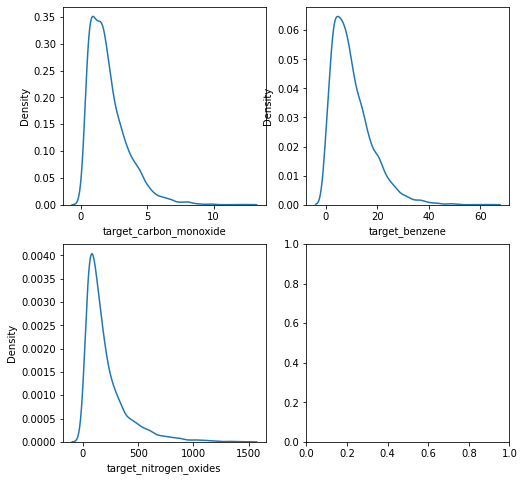

In [13]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
sns.kdeplot(data=train[TARGET_COLUMNS[0]],ax=axes[0,0])
sns.kdeplot(data=train[TARGET_COLUMNS[1]],ax=axes[0,1])
sns.kdeplot(data=train[TARGET_COLUMNS[2]],ax=axes[1,0])

### Insight:

* skewed target features ... try log transformation

In [14]:
for feature in TARGET_COLUMNS:
    train_df[feature] = feature_engineering.log_scaling(train_df[feature])

<AxesSubplot:xlabel='target_nitrogen_oxides', ylabel='Density'>

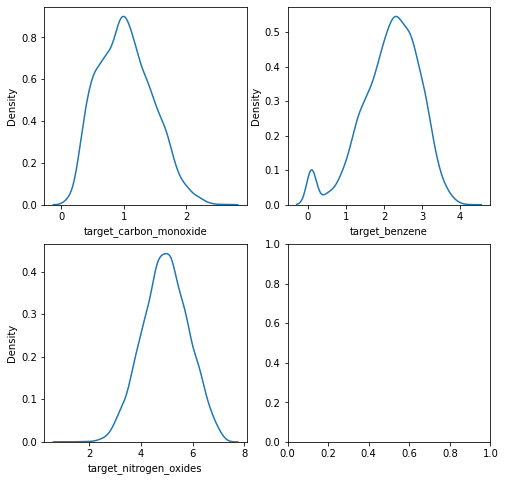

In [15]:
fig,axes = plt.subplots(2,2, figsize=(8,8))
sns.kdeplot(data=train_df[TARGET_COLUMNS[0]],ax=axes[0,0])
sns.kdeplot(data=train_df[TARGET_COLUMNS[1]],ax=axes[0,1])
sns.kdeplot(data=train_df[TARGET_COLUMNS[2]],ax=axes[1,0])

## Polynomial Features

In [16]:
def polynomial_features_fit_transform(df_train: pd.DataFrame, polynomial_args: dict) -> (pd.DataFrame, PolynomialFeatures):
    poly = PolynomialFeatures(**polynomial_args)
    poly.fit(df_train)
    return pd.DataFrame(poly.transform(df_train), index= df_train.index, columns=poly.get_feature_names(df_train.columns)), poly

In [17]:
def polynomial_features_transform(df_test: pd.DataFrame, polynomial_object) -> pd.DataFrame:
    return pd.DataFrame(polynomial_object.transform(df_test), index= df_test.index, columns=poly.get_feature_names(df_test.columns))

In [18]:
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

In [19]:
train_df_poly, poly = polynomial_features_fit_transform(train_df[NUM_FEATURE_COLUMNS], {'degree':2})
train_df_1 = train_df.drop(NUM_FEATURE_COLUMNS, axis=1)
train_df_1 = pd.concat([train_df_1,train_df_poly],axis=1)

test_df_poly = polynomial_features_transform(test_df[NUM_FEATURE_COLUMNS], poly)
test_df_1 = test_df.drop(NUM_FEATURE_COLUMNS, axis=1)
test_df_1 = pd.concat([test_df_1,test_df_poly],axis=1)

In [20]:
train_df = train_df_1.copy()
test_df = test_df_1.copy()

# Split Data

In [21]:
test_size = 0.33
test_idx = int(1-len(train)*test_size)

In [22]:
train_df_clean = train_df.drop(['date_time'], axis=1)
test_df_clean = test_df.drop(['date_time'], axis=1)
X_submission = test_df_clean.copy()

In [23]:
tr = train_df_clean.iloc[:test_idx]
te = train_df_clean.iloc[test_idx:]


X_train = tr.drop(TARGET_COLUMNS,axis=1)
y_train = tr[TARGET_COLUMNS[0]]

X_test = te.drop(TARGET_COLUMNS,axis=1)
y_test = te[TARGET_COLUMNS[0]]

# Scale Numerical Data

In [24]:
num_features = X_train.select_dtypes(include=np.number).columns

In [25]:
scaler = MinMaxScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])
X_submission[num_features] = scaler.transform(test_df_clean[num_features])

# Base Model Comparison

 60%|██████    | 6/10 [00:08<00:07,  1.81s/it]/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users

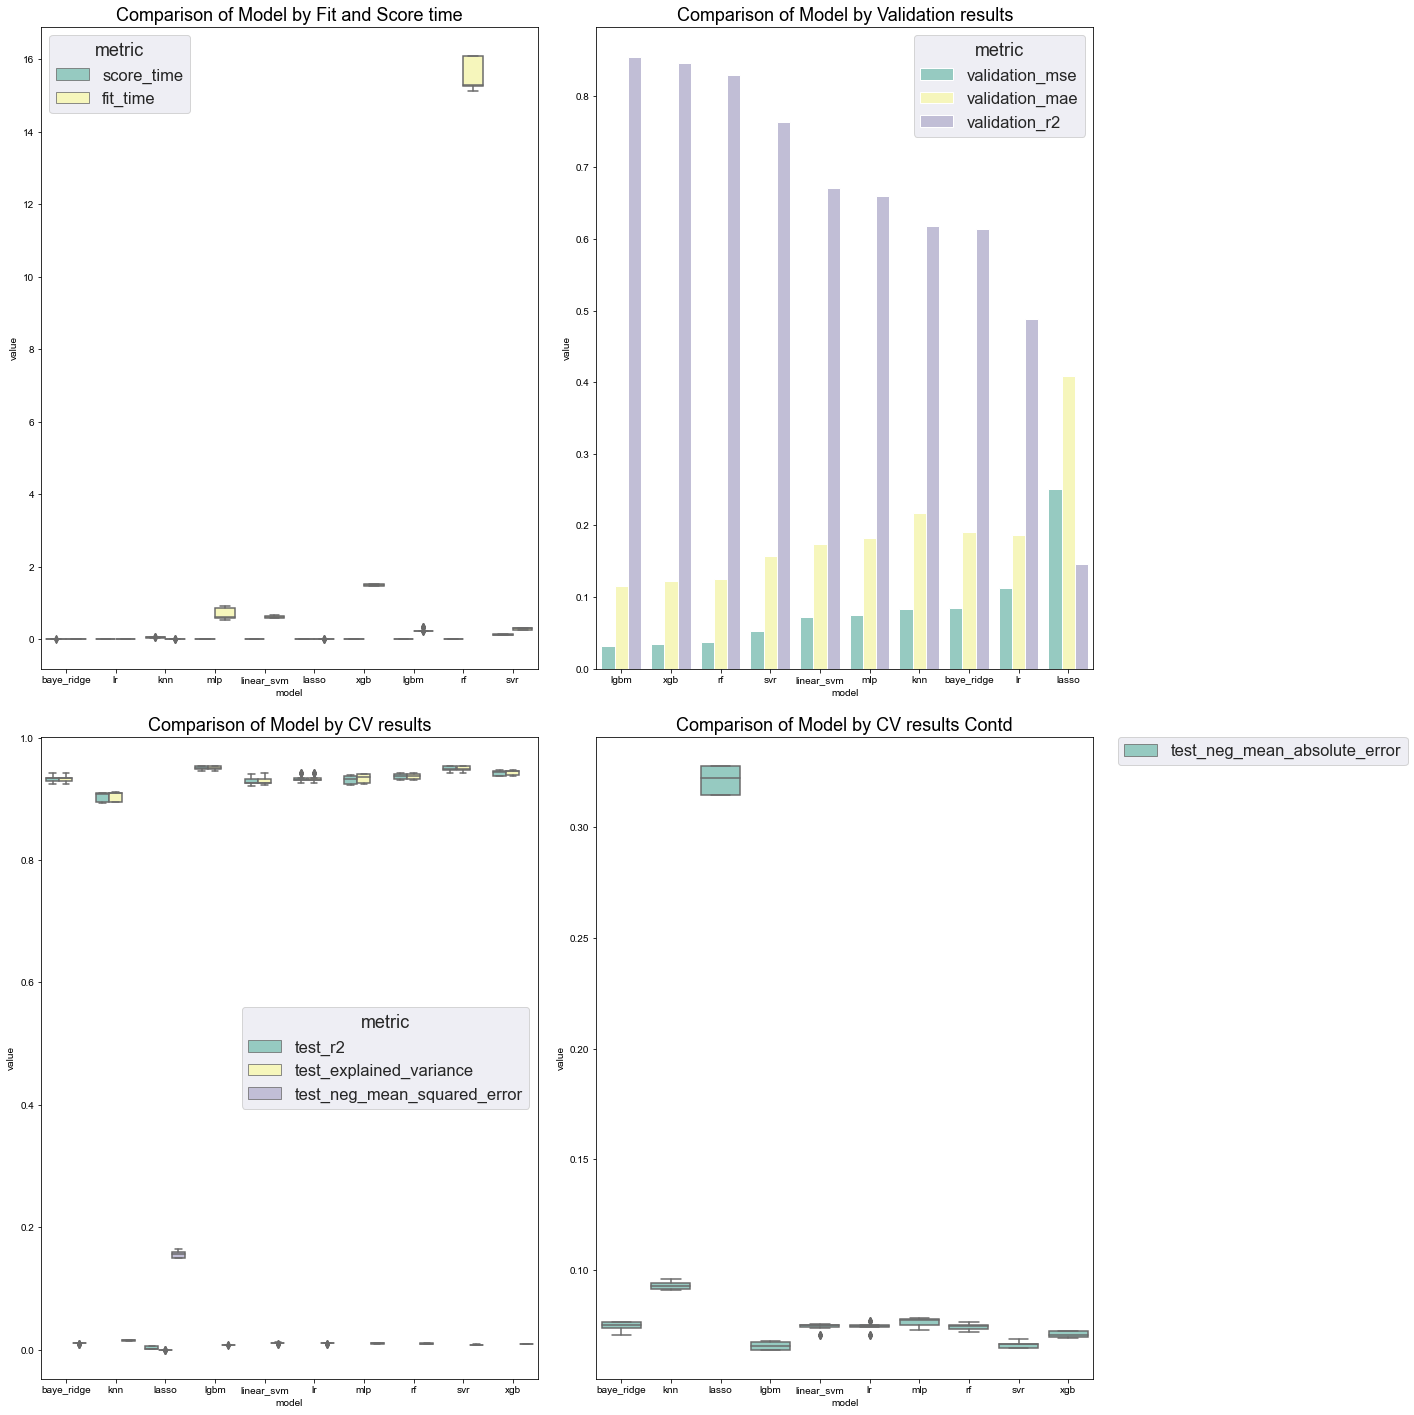

In [64]:
experiments_results = modelling.run_experiments(X_train, X_test, y_train, y_test, False)
experiments, _ = modelling.visualise_model_experiments(experiments_results)

In [65]:
experiments

fit_time        score_time       test_explained_variance        \
                std   mean        std  mean                     std  mean   
model                                                                       
baye_ridge    0.001  0.021      0.000 0.003                   0.005 0.934   
knn           0.000  0.003      0.009 0.058                   0.007 0.905   
lasso         0.000  0.006      0.000 0.003                   0.000 0.000   
lgbm          0.041  0.261      0.000 0.006                   0.002 0.951   
linear_svm    0.031  0.625      0.000 0.003                   0.007 0.930   
lr            0.001  0.016      0.001 0.004                   0.005 0.932   
mlp           0.159  0.706      0.001 0.004                   0.007 0.934   
rf            0.395 15.498      0.001 0.023                   0.004 0.936   
svr           0.022  0.295      0.008 0.141                   0.004 0.949   
xgb           0.019  1.499      0.000 0.005                   0.004 0.942   

           test_r2       test_neg_mean_absolute_error        \
               std  mean                          std  mean   
model                                                         
baye_ridge   0.005 0.934                        0.002 0.074   
knn          0.007 0.904                        0.002 0.093   
lasso        0.002 0.003                        0.006 0.322   
lgbm         0.002 0.951                        0.001 0.066   
linear_svm   0.007 0.929                        0.002 0.074   
lr           0.005 0.932                        0.002 0.074   
mlp          0.006 0.932                        0.002 0.076   
rf           0.004 0.936                        0.001 0.074   
svr          0.004 0.949                        0.001 0.066   
xgb          0.004 0.942                        0.001 0.071   

           test_neg_mean_squared_error       validation_r2        \
                                   std  mean           std  mean   
model                                                              
baye_ridge                       0.001 0.010         0.000 0.614   
knn                              0.001 0.015         0.000 0.619   
lasso                            0.005 0.156         0.000 0.145   
lgbm                             0.000 0.008         0.000 0.854   
linear_svm                       0.001 0.011         0.000 0.671   
lr                               0.001 0.011         0.000 0.488   
mlp                              0.001 0.011         0.000 0.659   
rf                               0.000 0.010         0.000 0.829   
svr                              0.001 0.008         0.000 0.763   
xgb                              0.000 0.009         0.000 0.846   

           validation_mse       validation_mae        
                      std  mean            std  mean  
model                                                 
baye_ridge          0.000 0.085          0.000 0.191  
knn                 0.000 0.084          0.000 0.217  
lasso               0.000 0.251          0.000 0.409  
lgbm                0.000 0.032          0.000 0.115  
linear_svm          0.000 0.072          0.000 0.173  
lr                  0.000 0.112          0.000 0.187  
mlp                 0.000 0.075          0.000 0.182  
rf                  0.000 0.038          0.000 0.125  
svr                 0.000 0.052          0.000 0.158  
xgb                 0.000 0.034          0.000 0.123

# Model training

In [35]:
for target in TARGET_COLUMNS:
    y_train = tr[target]
    y_test = te[target]
    ml = LGBMRegressor(n_estimators=1000).fit(X_train, y_train)

    preds = ml.predict(X_test)


    mse = round(mean_squared_error(y_test, preds),3)
    mae = round(mean_absolute_error(y_test, preds),3)
    r2 = round(r2_score(y_test, preds),3)
    print(f"{target}: mse: {mse}, mae: {mae}, r2: {r2}")

target_carbon_monoxide: mse: 0.031, mae: 0.115, r2: 0.857
target_benzene: mse: 0.009, mae: 0.073, r2: 0.987
target_nitrogen_oxides: mse: 0.201, mae: 0.326, r2: 0.647


target_carbon_monoxide: mse: 0.032, mae: 0.115, r2: 0.854
target_benzene: mse: 0.009, mae: 0.073, r2: 0.987
target_nitrogen_oxides: mse: 0.198, mae: 0.323, r2: 0.651

## First Classical Submission Model Training

In [28]:
submission = pd.DataFrame(index=test_df['date_time'])

for target in TARGET_COLUMNS:
    y_train = tr[target]
    ml = LGBMRegressor().fit(X_train, y_train)

    # preds = ml.predict(X_test)
    #
    #
    # mse = round(mean_squared_error(y_test, preds),3)
    # mae = round(mean_absolute_error(y_test, preds),3)
    # r2 = round(r2_score(y_test, preds),3)
    # print(f"{target}: mse: {mse}, mae: {mae}, r2: {r2}")
    submission[target] = feature_engineering.inverse_log_scaling(ml.predict(X_submission))


In [31]:
submission.reset_index().to_csv(f'submission_{utils.current_timestamp()}.csv', index=False)